In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.metrics import mean_squared_log_error as MSLE
 
#Machine Learning Models:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from sklearn.svm import SVR    #didn't work properly

from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

#### **Reading training and testing datasets**

In [2]:
train_df = pd.read_csv('/kaggle/input/seoul-bike-rental-ai-pro-iti/train.csv')
test_df = pd.read_csv('/kaggle/input/seoul-bike-rental-ai-pro-iti/test.csv')
# train_df = train_df.set_index("ID")

#### **Training dataset EDA**

In [3]:
train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         5760 non-null   int64  
 1   Date                       5760 non-null   object 
 2   y                          5760 non-null   int64  
 3   Hour                       5760 non-null   int64  
 4   Temperature(�C)            5760 non-null   float64
 5   Humidity(%)                5760 non-null   int64  
 6   Wind speed (m/s)           5760 non-null   float64
 7   Visibility (10m)           5760 non-null   int64  
 8   Dew point temperature(�C)  5760 non-null   float64
 9   Solar Radiation (MJ/m2)    5760 non-null   float64
 10  Rainfall(mm)               5760 non-null   float64
 11  Snowfall (cm)              5760 non-null   float64
 12  Seasons                    5760 non-null   object 
 13  Holiday                    5760 non-null   objec

In [5]:
train_df.describe()

,ID,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000
mean,2879.500000,703.483854,11.500000,12.803559,58.361806,1.723333,1473.711458,4.058264,0.572325,0.135122,0.046302
std,1662.913107,655.249491,6.922788,11.902206,19.840167,1.047898,585.879880,13.003582,0.869943,1.075320,0.323728
min,0.000000,0.000000,0.000000,-15.100000,0.000000,0.000000,27.000000,-26.900000,0.000000,0.000000,0.000000
25%,1439.750000,188.000000,5.750000,3.200000,43.000000,0.900000,1025.750000,-5.400000,0.000000,0.000000,0.000000
50%,2879.500000,485.500000,11.500000,13.700000,57.000000,1.500000,1732.000000,5.200000,0.010000,0.000000,0.000000
75%,4319.250000,1066.000000,17.250000,22.225000,73.000000,2.300000,2000.000000,14.700000,0.940000,0.000000,0.000000
max,5759.000000,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000


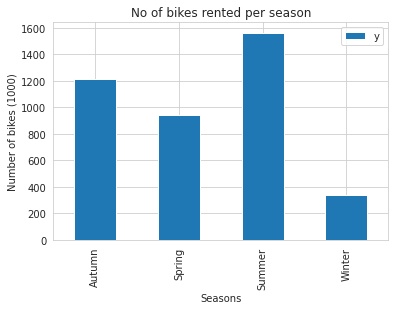

In [6]:
bikes_per_season= train_df[["Seasons", "y"]].groupby("Seasons").sum()/1000
bikes_per_season.plot.bar()
plt.xlabel('Seasons'), plt.ylabel('Number of bikes (1000)')
plt.title("No of bikes rented per season")
plt.show()

- The rental rate grows at summer, and drops greatly at winter.
- The Seasons cycle is Winter->Spring->Summer->Autumn.

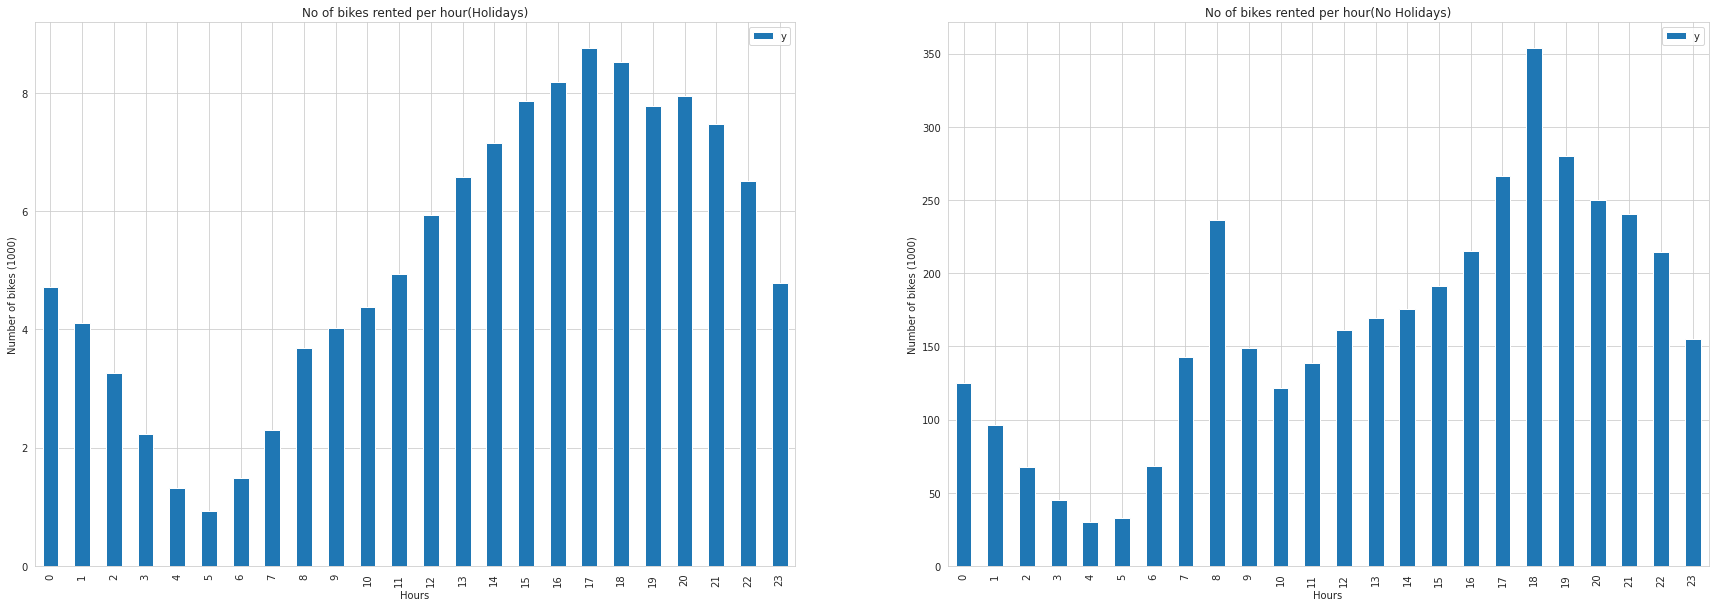

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (30, 10))

holidays = train_df[train_df["Holiday"]=='Holiday']
bikes_per_hour_holidays = holidays[['Hour','y']].groupby('Hour').sum()/1000

no_holidays = train_df[train_df["Holiday"]=='No Holiday']
bikes_per_hour_noholidays = no_holidays[['Hour','y']].groupby('Hour').sum()/1000

bikes_per_hour_holidays.plot(ax=ax[0],
                             kind='bar',
                             title= "No of bikes rented per hour(Holidays)",
                             xlabel= 'Hours',
                             ylabel= 'Number of bikes (1000)')


bikes_per_hour_noholidays.plot(ax=ax[1],
                               kind='bar',
                               title= "No of bikes rented per hour(No Holidays)",
                               xlabel= 'Hours',
                               ylabel= 'Number of bikes (1000)')

plt.show()

##### It looks like holidays follow a similar pattern to no holidays, but holidays represent only 4% of all data. Let's investigate further.

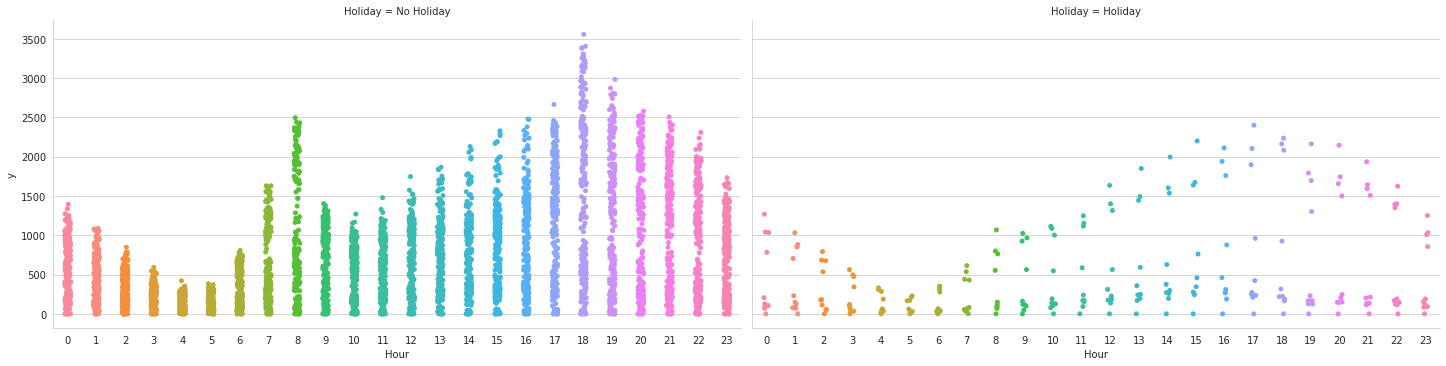

In [8]:
sns.catplot(data=train_df,
           x='Hour',
           y='y',
           col='Holiday',
           aspect=2)
plt.show()

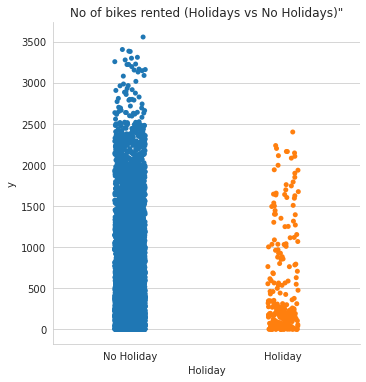

In [9]:
sns.catplot(data=train_df,
           x="Holiday",
           y="y")

plt.title('No of bikes rented (Holidays vs No Holidays)"')
plt.show()

##### Conclusion:
- Rental rates increase around the period (10-18). -> try adding 'active_hours' feature.
- Holidays follow a similar pattern to No Holydays.
- Holidays represent 4% of all data, so maybe its an inreliable feature -> try dropping 'Holiday' feature.

In [10]:
train_df[train_df["Functioning Day"] == "No"].describe()

,ID,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,247.000000,247.0,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.0
mean,4537.153846,0.0,11.259109,15.776518,61.457490,1.704049,1435.599190,7.683401,0.618219,0.162753,0.0
std,1086.925930,0.0,6.989951,4.966131,16.734573,1.100140,595.276841,4.531857,0.907081,1.314363,0.0
min,2160.000000,0.0,0.000000,5.200000,21.000000,0.000000,201.000000,-7.000000,0.000000,0.000000,0.0
25%,4741.500000,0.0,5.000000,11.800000,49.000000,0.900000,920.000000,5.250000,0.000000,0.000000,0.0
50%,4875.000000,0.0,11.000000,15.500000,64.000000,1.500000,1714.000000,7.600000,0.000000,0.000000,0.0
75%,5337.500000,0.0,17.000000,19.300000,74.000000,2.400000,1992.000000,10.800000,1.095000,0.000000,0.0
max,5495.000000,0.0,23.000000,26.500000,96.000000,5.300000,2000.000000,16.100000,3.320000,18.000000,0.0


##### It seams that the number of rented bikes on no-functioning days is zero regardless of the values of other features.

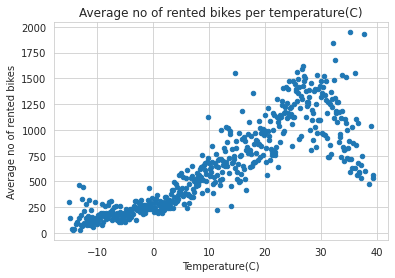

In [11]:
temperature_rental_rates = train_df.groupby('Temperature(�C)',as_index=False)['y'].mean()

temperature_rental_rates.plot(x='Temperature(�C)',
                              y='y',
                              kind='scatter',
                              title= "Average no of rented bikes per temperature(C)",
                              xlabel= 'Temperature(C)',
                              ylabel= 'Average no of rented bikes')
plt.show()

- We can see that the average no. of rented bikes increases with temperature until (~27C)-> try adding 'cool_temp' feature.

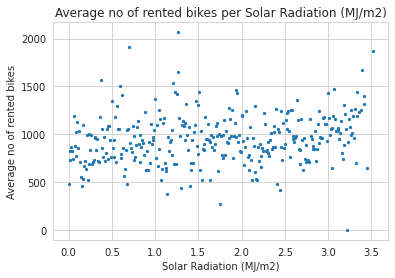

In [12]:
solar_rad = train_df.groupby('Solar Radiation (MJ/m2)',as_index=False)['y'].mean()
solar_rad.plot(x='Solar Radiation (MJ/m2)',
               y='y',
               kind='scatter',
               marker='.',
               title= "Average no of rented bikes per Solar Radiation (MJ/m2)",
               ylabel= 'Average no of rented bikes')
plt.show()

- There's no clear pattern between solar radiation and average bike rental -> try dropping 'Solar Radiation (MJ/m2)' feature
- The correlation between 'y' and 'Solar Radiation (MJ/m2)' is 0.25

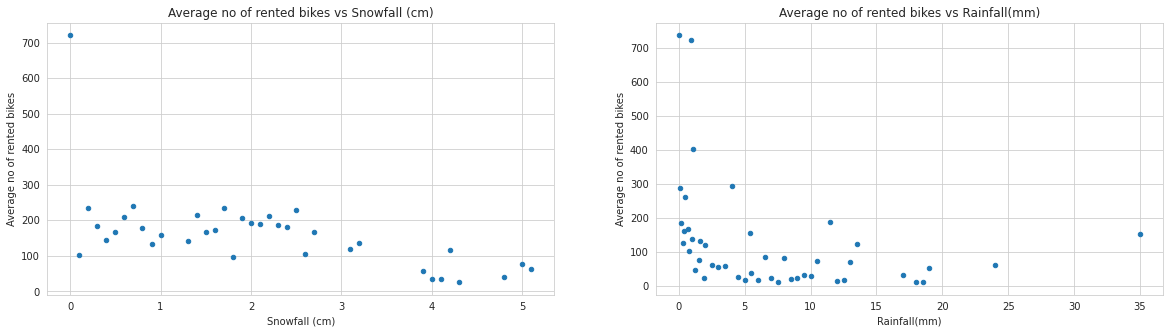

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

snow_fall = train_df.groupby(['Snowfall (cm)'],as_index=False)['y'].mean()
snow_fall.plot(ax=ax[0],
               x='Snowfall (cm)',
               y='y',
               kind='scatter',
               title= "Average no of rented bikes vs Snowfall (cm)",
               ylabel= 'Average no of rented bikes')

rain_fall = train_df.groupby(['Rainfall(mm)'],as_index=False)['y'].mean()
rain_fall.plot(ax=ax[1],
               x='Rainfall(mm)',
               y='y',
               kind='scatter',
               title= "Average no of rented bikes vs Rainfall(mm)",
               ylabel= 'Average no of rented bikes')

plt.show()

- Both features indicate that the average no of bikes rented decreases as they increase.

In [14]:
rain_rate = train_df.groupby(['Seasons'],as_index=False)[['Rainfall(mm)','y']].sum()
rain_rate

,Seasons,Rainfall(mm),y
0,Autumn,210.0,1214630
1,Spring,305.3,940276
2,Summer,247.1,1563416
3,Winter,15.9,333745


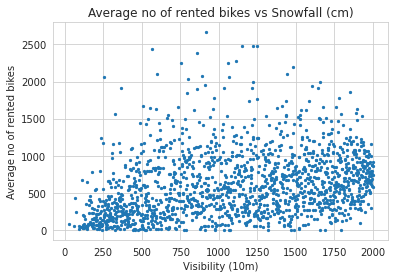

In [15]:
visibility = train_df.groupby(['Visibility (10m)'],as_index=False)['y'].mean()
visibility.plot(x='Visibility (10m)',
                y='y',
                kind='scatter',
                marker='.',
                title= "Average no of rented bikes vs Snowfall (cm)",
                ylabel= 'Average no of rented bikes')
plt.show()

- There's no clear relation between Visibility and average no. of bikes rented.
- At very low Visibility(0-150), the average no of bikes rented is very low, which makes sense. -> try encoding Visibility.

##### Let's investigate months and days of week:

In [16]:
for df in [train_df, test_df]:
    #Change its type to datetime: 
    df["Date"] = pd.to_datetime(df["Date"], 
                                format = "%d/%m/%Y", 
                                errors = "coerce")
    #Create "Month" column:
    df["Month"] = df["Date"].dt.month
    #Create "Year" column:
    df["Year"] = df["Date"].dt.year
    #create "Day of week" column (Each day takes a number: Monday=0, Sunday=6):
    df['Day of week'] = df['Date'].dt.dayofweek
    #Return the order of the week in the year:
    df["Week of year"] = df['Date'].dt.isocalendar().week.astype(int)

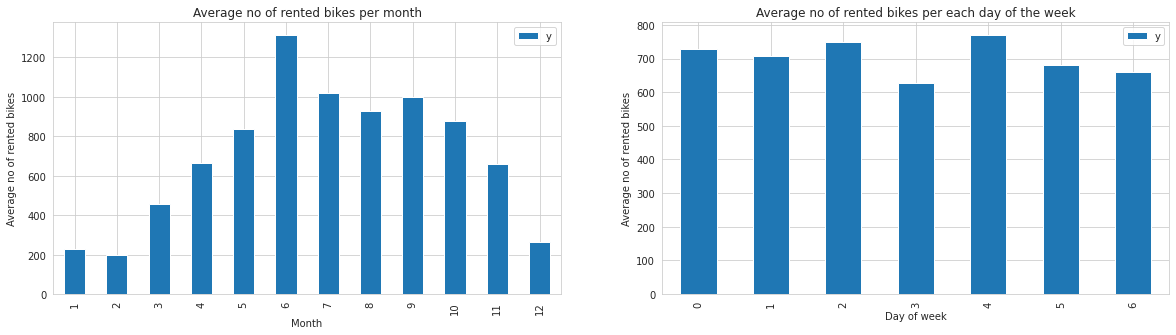

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

months = train_df.groupby(['Month'],as_index=False)['y'].mean()
months.plot(ax=ax[0],
            x='Month',
            y='y',
            kind='bar',
            title= "Average no of rented bikes per month",
            ylabel= 'Average no of rented bikes')

days_of_week = train_df.groupby(['Day of week'],as_index=False)['y'].mean()
days_of_week.plot(ax=ax[1],
                  x='Day of week',
                  y='y',
                  kind='bar',
                  title= "Average no of rented bikes per each day of the week",
                  ylabel= 'Average no of rented bikes')
plt.show()


- Months seems to be connected to seasons so it might not be helpful to add it.
- Weekends (Saturday& Sunday) have a lower average of rented bikes than the rest of the week, but Thursday has a low average as well.

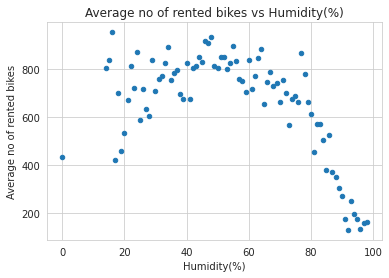

In [18]:
humidity = train_df.groupby(['Humidity(%)'],as_index=False)['y'].mean()
humidity.plot(x='Humidity(%)',
              y='y',
              kind='scatter',
              title= "Average no of rented bikes vs Humidity(%)",
              ylabel= 'Average no of rented bikes')
plt.show()

- The average no of bikes rented drops rapidly at high Humidity percentages(from ~60%). -> try to encode 'Humidity(%)'

<AxesSubplot:xlabel='Visibility (10m)', ylabel='Humidity(%)'>

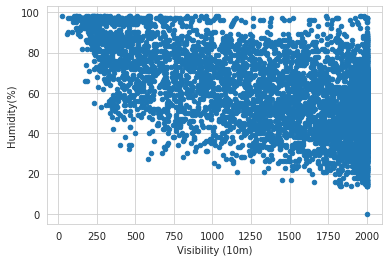

In [19]:
train_df.plot(kind='scatter',
              x='Visibility (10m)',
              y='Humidity(%)')

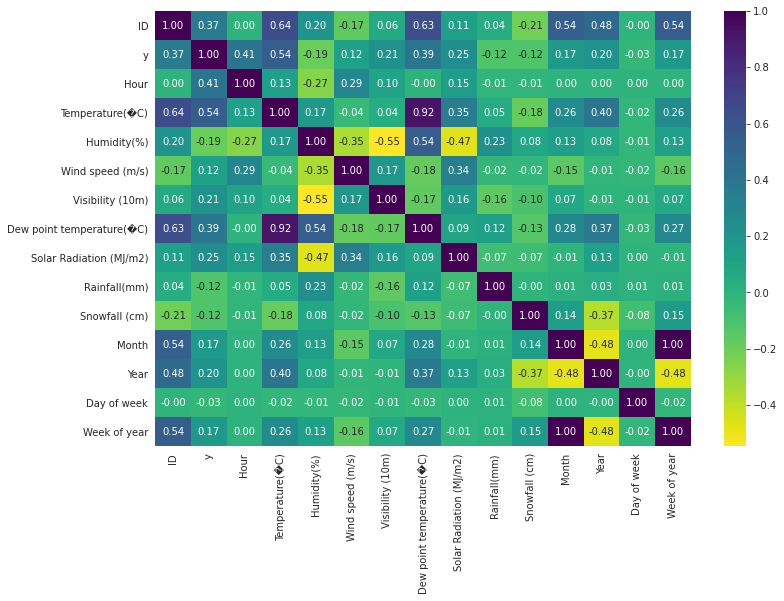

In [20]:
plt.figure(figsize = [12, 8])
sns.heatmap(train_df.corr(),annot = True, cmap = 'viridis_r', fmt = '.2f');

- We can see that 'Tempreature' and 'Dew Point Temperature' are highly correlated -> try dropping 'Dew Point Temperature' feature.

#### **Data preprocessing:**

In [21]:
#Lets take another look on the columns:
train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Month,Year,Day of week,Week of year
0,0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,4,48
1,1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,4,48
2,2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,4,48
3,3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,4,48
4,4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,4,48


### **Dealing with "Functioning Day" feature:**
#### - If "Functioning Day" feature is "No" then y=0.
#### - If it is "Yes", if doesn't affect the value of y.
#### - We will remove this column and remove all rows with ("Functioning Day" = No) from training data, and train the model on the rest of the data.
#### - To get the correct y value: we will multyply the output of the model by zero when ("Functioning Day" = No).

In [22]:
#Keep "Functioning Day" column of test data to correct the o/p:
test_func_day = test_df["Functioning Day"]

#Remove rows with (Function Day = No) from training data:
train_df = train_df[train_df["Functioning Day"] == "Yes"]

#Drop "Function Day" column from train and test datasets
for df in [train_df, test_df]:
    df.drop(columns="Functioning Day", inplace=True)

train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Month,Year,Day of week,Week of year
0,0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,2017,4,48
1,1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,2017,4,48
2,2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,12,2017,4,48
3,3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,2017,4,48
4,4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,12,2017,4,48


#### Factorize Catigorical Features("Seasons", "Holiday"):

In [23]:
for df in [train_df, test_df]:
    df["Holiday"] = df["Holiday"].map({"No Holiday":0, "Holiday":1, 1:1, 0:0})
    # Use onehotencoder method on seasons:
    df[['Spring', 'Summer', 'Winter']] = pd.get_dummies(df["Seasons"], drop_first=True)
    
train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),...,Snowfall (cm),Seasons,Holiday,Month,Year,Day of week,Week of year,Spring,Summer,Winter
0,0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,...,0.0,Winter,0,12,2017,4,48,0,0,1
1,1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,...,0.0,Winter,0,12,2017,4,48,0,0,1
2,2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,...,0.0,Winter,0,12,2017,4,48,0,0,1
3,3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,...,0.0,Winter,0,12,2017,4,48,0,0,1
4,4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,...,0.0,Winter,0,12,2017,4,48,0,0,1


#### Add Active hours feature (10-18):

In [24]:
bins = [-1, 7.5, 18.5, 24]
labels = [0, 1, 0] # 1: hours in [7-18], 0: hours not in [7-18]
for df in [train_df, test_df]:
    df["Active hours"] = pd.cut(df["Hour"], bins=bins, labels=labels, ordered=False).astype(int)
    
train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),...,Seasons,Holiday,Month,Year,Day of week,Week of year,Spring,Summer,Winter,Active hours
0,0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,...,Winter,0,12,2017,4,48,0,0,1,0
1,1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,...,Winter,0,12,2017,4,48,0,0,1,0
2,2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,...,Winter,0,12,2017,4,48,0,0,1,0
3,3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,...,Winter,0,12,2017,4,48,0,0,1,0
4,4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,...,Winter,0,12,2017,4,48,0,0,1,0


#### Encode Visibility:

In [25]:
bins = [0, 150.1, 2001]
labels = [1, 0] # 1: low_visibility[0-150], 0: normal visibility [150-2000]
for df in [train_df, test_df]:
    df["low_visibility"] = pd.cut(df["Visibility (10m)"], bins=bins, labels=labels).astype(float)
    
train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),...,Holiday,Month,Year,Day of week,Week of year,Spring,Summer,Winter,Active hours,low_visibility
0,0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,...,0,12,2017,4,48,0,0,1,0,0.0
1,1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,...,0,12,2017,4,48,0,0,1,0,0.0
2,2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,...,0,12,2017,4,48,0,0,1,0,0.0
3,3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,...,0,12,2017,4,48,0,0,1,0,0.0
4,4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,...,0,12,2017,4,48,0,0,1,0,0.0


#### Cyclical features transform (Hour, Month):

In [26]:
for df in [train_df, test_df]:
    for feature in ["Hour", "Month"]:
        df[feature+"_sin"] = np.sin(2 * np.pi * df[feature]/df[feature].max())
        df[feature+"_cos"] = np.sin(2 * np.pi * df[feature]/df[feature].max())
        
train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),...,Week of year,Spring,Summer,Winter,Active hours,low_visibility,Hour_sin,Hour_cos,Month_sin,Month_cos
0,0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,...,48,0,0,1,0,0.0,0.000000,0.000000,-2.449294e-16,-2.449294e-16
1,1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,...,48,0,0,1,0,0.0,0.269797,0.269797,-2.449294e-16,-2.449294e-16
2,2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,...,48,0,0,1,0,0.0,0.519584,0.519584,-2.449294e-16,-2.449294e-16
3,3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,...,48,0,0,1,0,0.0,0.730836,0.730836,-2.449294e-16,-2.449294e-16
4,4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,...,48,0,0,1,0,0.0,0.887885,0.887885,-2.449294e-16,-2.449294e-16


#### Feature Interactions:

In [27]:
for df in [train_df, test_df]:
    df["SR*T"] = df["Solar Radiation (MJ/m2)"]*df["Temperature(�C)"]
    df["rain+snow"] = df["Rainfall(mm)"] +10*df["Snowfall (cm)"]

train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),...,Summer,Winter,Active hours,low_visibility,Hour_sin,Hour_cos,Month_sin,Month_cos,SR*T,rain+snow
0,0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,...,0,1,0,0.0,0.000000,0.000000,-2.449294e-16,-2.449294e-16,-0.0,0.0
1,1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,...,0,1,0,0.0,0.269797,0.269797,-2.449294e-16,-2.449294e-16,-0.0,0.0
2,2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,...,0,1,0,0.0,0.519584,0.519584,-2.449294e-16,-2.449294e-16,-0.0,0.0
3,3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,...,0,1,0,0.0,0.730836,0.730836,-2.449294e-16,-2.449294e-16,-0.0,0.0
4,4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,...,0,1,0,0.0,0.887885,0.887885,-2.449294e-16,-2.449294e-16,-0.0,0.0


### **Model Training:**

#### Split train data into training & validation sets:

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5513 entries, 0 to 5759
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         5513 non-null   int64         
 1   Date                       5513 non-null   datetime64[ns]
 2   y                          5513 non-null   int64         
 3   Hour                       5513 non-null   int64         
 4   Temperature(�C)            5513 non-null   float64       
 5   Humidity(%)                5513 non-null   int64         
 6   Wind speed (m/s)           5513 non-null   float64       
 7   Visibility (10m)           5513 non-null   int64         
 8   Dew point temperature(�C)  5513 non-null   float64       
 9   Solar Radiation (MJ/m2)    5513 non-null   float64       
 10  Rainfall(mm)               5513 non-null   float64       
 11  Snowfall (cm)              5513 non-null   float64       
 12  Season

In [29]:
#For XGBoost model:
# selected_features =["Hour","Month","Active hours","Day of week","Humidity(%)","Wind speed (m/s)",
#                     "Visibility (10m)","Solar Radiation (MJ/m2)","Rainfall(mm)","Snowfall (cm)",
#                     "Spring","Summer","Winter","Cool temperature","low_visibility"]

#For CatBoost model:
selected_features = ["Hour","Month","Day of week","Wind speed (m/s)","Seasons","Holiday","Humidity(%)","rain+snow",
                     "Solar Radiation (MJ/m2)","Rainfall(mm)","Snowfall (cm)","Temperature(�C)"]
cat_feat_index=np.array([4,5])


X_train, X_val, y_train, y_val = train_test_split(train_df[selected_features],
                                                  train_df["y"],
                                                  test_size = 0.2,
                                                  stratify = train_df["Hour"],
                                                  random_state=0)
X_train.head()

,Hour,Month,Day of week,Wind speed (m/s),Seasons,Holiday,Humidity(%),rain+snow,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Temperature(�C)
585,9,1,4,1.2,Winter,0,49,0.0,0.12,0.0,0.0,-4.7
2645,5,5,4,1.5,Spring,0,84,0.0,0.00,0.0,0.0,11.9
2864,8,5,6,1.0,Spring,0,38,0.0,0.72,0.0,0.0,14.1
2031,15,4,3,1.9,Spring,0,96,0.5,0.26,0.5,0.0,8.1
751,7,1,4,0.9,Winter,0,45,0.0,0.00,0.0,0.0,-15.1


#### Model Testing:

In [30]:
#Esrimate model R2 score and RMSLE Error:
def estimate_model(model, X_train, X_val, y_train, y_val, flip_neg_pred=False):
    y_pred_train = np.round(model.predict(X_train)) 
    y_pred_val = np.round(model.predict(X_val))
    
    if flip_neg_pred:
        y_pred_train[y_pred_train<0] *= -1
        y_pred_val[y_pred_val<0] *= -1
        
    print(f"  Training set R2 score   = {model.score(X_train, y_train)*100}%\n  Validation set R2 score = {model.score(X_val, y_val)*100}%\n")
    RMSLE_train = np.sqrt(MSLE(y_train, y_pred_train))
    RMSLE_val = np.sqrt(MSLE(y_val, y_pred_val))
    print(f"  Training set RMSLE   = {RMSLE_train} \n  Validation set RMSLE = {RMSLE_val}")

In [31]:
#View the most predictive features from any tree-based model:
def feature_importance(model):
    importance = pd.DataFrame(model.feature_importances_, index= X_train.columns).sort_values(0)
    importance.plot(kind='barh'), plt.show()

In [32]:
from sklearn.model_selection import cross_val_score
def coss_val(model,X,y,cv=10):
    scores=cross_val_score(model, X, y, cv=cv)
    print("%0.5f accuracy with a standard deviation of %0.5f" % (scores.mean(), scores.std()))

In [33]:
# print('XGB Regression model:')
# model = XGBRegressor (eval_metric='rmsle',
#                       objective="reg:tweedie",
#                       grow_policy='lossguide',
#                       tree_method='gpu_hist',
#                       max_depth=20,
#                       n_estimators=1000,
#                       min_child_weight=12,
#                       subsample=0.6,
#                       gamma=0,
#                       eta=0.01,
#                       seed=42)

# model.fit(X_train, y_train, eval_metric="rmsle")
# estimate_model(model, X_train, X_val, y_train, y_val, flip_neg_pred=True)
# feature_importance(model)

CatBoost Regressor:
  Training set R2 score   = 94.71378732476501%
  Validation set R2 score = 94.56767918213677%

  Training set RMSLE   = 0.30023425639010376 
  Validation set RMSLE = 0.3002904667877222


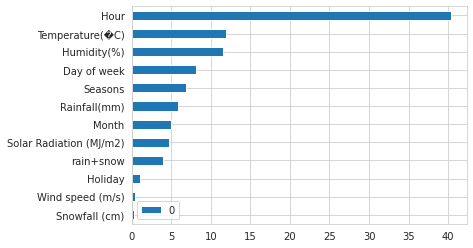

In [34]:
print("CatBoost Regressor:")
model = CatBoostRegressor(random_seed=42,
                          loss_function='Tweedie:variance_power=1.945',
                          eval_metric="MSLE",
                          bootstrap_type='MVS',
                          n_estimators=1260,
                          learning_rate=0.032,
                          l2_leaf_reg=50,
                          sampling_frequency="PerTree",
                          cat_features=cat_feat_index,
                          logging_level='Silent')
model.fit(X_train, y_train)
# coss_val(model,X_train,y_train,10)
estimate_model(model, X_train, X_val, y_train, y_val)
feature_importance(model)

### **Test Set Predictions:**

In [35]:
X_test = test_df[selected_features]
X_test

,Hour,Month,Day of week,Wind speed (m/s),Seasons,Holiday,Humidity(%),rain+snow,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Temperature(�C)
0,0,12,3,2.0,Winter,0,90,22.0,0.0,0.0,2.2,-1.3
1,1,12,3,1.6,Winter,0,90,22.0,0.0,0.0,2.2,-1.8
2,2,12,3,1.4,Winter,0,88,22.0,0.0,0.0,2.2,-2.2
3,3,12,3,1.3,Winter,0,89,22.0,0.0,0.0,2.2,-2.9
4,4,12,3,1.2,Winter,0,91,22.0,0.0,0.0,2.2,-3.6
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,19,11,4,2.6,Autumn,0,34,0.0,0.0,0.0,0.0,4.2
2996,20,11,4,2.3,Autumn,0,37,0.0,0.0,0.0,0.0,3.4
2997,21,11,4,0.3,Autumn,0,39,0.0,0.0,0.0,0.0,2.6
2998,22,11,4,1.0,Autumn,0,41,0.0,0.0,0.0,0.0,2.1


In [36]:
y_test = np.round(model.predict(X_test)).astype(int)
# y_test[y_test < 0] *= -1 #transform negative predictions to positive

#Use functioning day column to get the correct output:
test_func_day = test_func_day.map({"Yes":1, "No":0, 1:1, 0:0})
y_test *= test_func_day

test_df["y"] = y_test


submission = test_df[["ID", "y"]]
submission

,ID,y
0,5760,136
1,5761,118
2,5762,106
3,5763,68
4,5764,46
...,...,...
2995,8755,1000
2996,8756,896
2997,8757,843
2998,8758,744


#### Save Submission File:

In [37]:
submission.to_csv('/kaggle/working/submission.csv', index=False)